In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('fashion-mnist_train.csv')
df = df.sample(10000)



In [2]:
import torch
from sklearn.metrics import pairwise_distances

def silhouette(X, y):
    
    if not torch.is_tensor(y):
        y = torch.from_numpy(y).float()
    
    distances = pairwise_distances(X, metric='cosine')
    distances = torch.from_numpy(distances).float()
    weighted_distances = torch.matmul(distances, y)
    sum_p = torch.sum(y, dim = 0)
    sum_p_mat = torch.empty(y.shape[0], y.shape[1])
    for i in range(y.shape[0]):
        sum_p_mat[i] = sum_p - y[i]
    alphas = torch.div(weighted_distances, sum_p)
    betas = torch.empty(alphas.shape[0], alphas.shape[1])
    for i in range(alphas.shape[0]):
        for j in range(alphas.shape[1]):
            betas[i][j] = min([alphas[i][x] for x in range(alphas.shape[1]) if x!=j])
    max_ab = torch.max(alphas, betas)
    s = betas - alphas
    s = torch.div(s, max_ab)
    s = s*y
    s = torch.sum(s, dim=1)
    s = torch.mean(s)
    return s

In [3]:
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score


def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

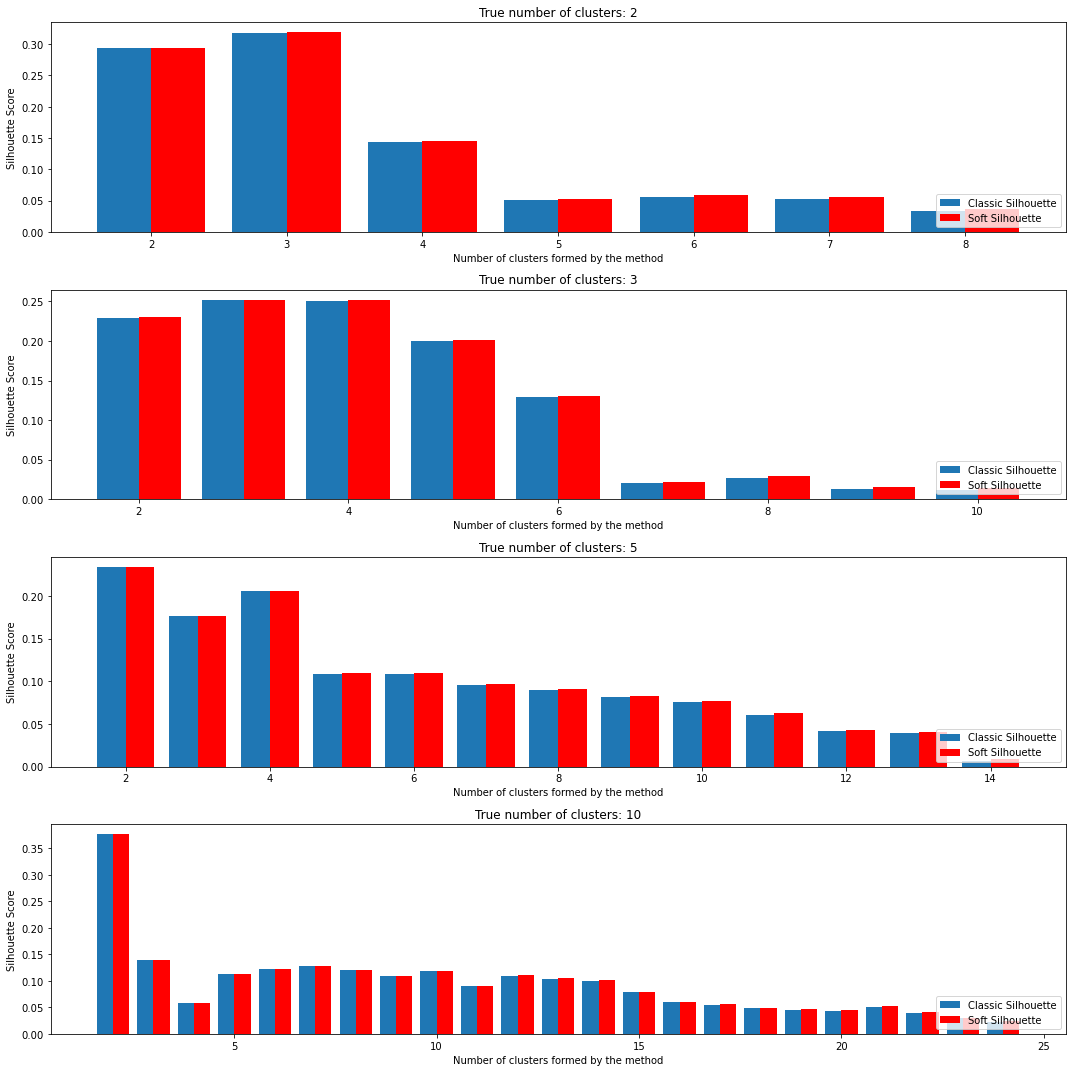

<Figure size 1500x1500 with 0 Axes>

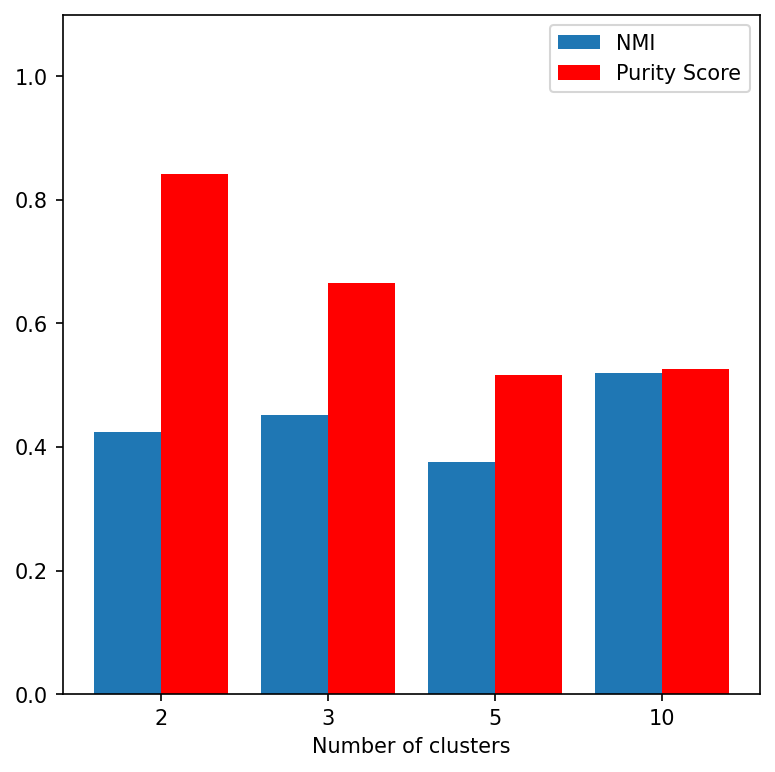

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from matplotlib.pyplot import figure

n_clusters = [2, 3, 5, 10]
purity_scores = []
nmi_scores = []

fig_scores, axs_scores = plt.subplots(4, 1,figsize=(15,15))
for n in n_clusters:
    X = df[df['label'] < n]
    y = np.array(X['label'])
    X = np.array(X.drop('label', axis=1))
    X = X/255.0
    
    soft_score = []
    score = []
    n_alg_clusters = []
    for i in range(2,2*n+5):
        n_alg_clusters.append(i)
        gm = GaussianMixture(n_components=i, random_state=0).fit(X)
        probabilities = gm.predict_proba(X)
        probabilities = np.around(probabilities, decimals=6)
        maxprob_index = np.argmax(probabilities, axis=-1)
        if i==n:
            purity_scores.append(purity_score(y, maxprob_index))
            nmi_scores.append(normalized_mutual_info_score(y, maxprob_index))


        score.append(metrics.silhouette_score(X, maxprob_index, metric='cosine'))
        soft_score.append(silhouette(X, probabilities))

    _X = np.arange(len(n_alg_clusters))
    y_axs = n_clusters.index(n)
    axs_scores[y_axs].bar(_X+2-0.2,score, width=0.4, label='Classic Silhouette')
    axs_scores[y_axs].bar(_X+2+0.2,soft_score, width=0.4, label='Soft Silhouette', color='red')
    axs_scores[y_axs].set_title(f'True number of clusters: {n}')
    axs_scores[y_axs].legend(loc="lower right")
    axs_scores[y_axs].set_xlabel('Number of clusters formed by the method')
    axs_scores[y_axs].set_ylabel('Silhouette Score')
    
fig_scores.tight_layout()
figure(figsize=(6, 6), dpi=250)
plt.show()

figure(figsize=(6, 6), dpi=150)

_X = np.arange(len(n_clusters))
plt.bar(_X-0.2, nmi_scores, width=0.4, label='NMI')
plt.bar(_X+0.2, purity_scores, width=0.4, label='Purity Score', color='red')
plt.xticks(_X, n_clusters)

plt.ylim(top=1.1)
plt.legend(loc="upper right")
plt.xlabel('Number of clusters')
plt.show()